# Machine Translation

Небольшой проект по переводу текста с русского языка на английский

## 0. For Colab

In [1]:
# !pip install datasets
# from google.colab import drive
# drive.mount('/content/drive')

# %cd /content/drive/MyDrive/machine_translation/

## 1. Data

Я выбрал корпус текстов OpenSubtitle (http://www.opensubtitles.org/) с ресурса OPUS (https://opus.nlpl.eu/OpenSubtitles/ru&en/v2018/OpenSubtitles)

Раскомментируйте ячейку снизу и запустите ее для скачивания данных или сделайте это вручную

**Предупреждаю сразу**: мощности не позволяют воспользоваться всем датасетом! К сожалению, придется ограничиться лишь небольшой долей от него. Поэтому я возьму всего миллион строчек и буду работать с ними

In [2]:
# !wget -q -O data/en-ru.txt.zip https://object.pouta.csc.fi/OPUS-OpenSubtitles/v2018/moses/en-ru.txt.zip
# !unzip data/en-ru.txt.zip -d data
# !mv data/OpenSubtitles.en-ru.en data/en.txt
# !mv data/OpenSubtitles.en-ru.ru data/ru.txt
# !rm data/en-ru.txt.zip
# !rm data/OpenSubtitles.en-ru.ids

Для удобства, все нужные данные я засунул в один `csv` файл. Раскомментируйте ячейку снизу и выполните код

In [3]:
# import pandas as pd

# N = 1_000_000

# with open("data/ru.txt", "r") as f_ru, open("data/en.txt", "r") as f_en:
#     ru_lines = [s.strip() for s in f_ru.readlines()[:N]]
#     en_lines = [s.strip() for s in f_en.readlines()[:N]]

#     pd.DataFrame({"ru": ru_lines, "en": en_lines}).to_csv("data/data.csv", index=False)

In [4]:
import random
import os
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import DataLoader
from torchtext.vocab import Vocab, build_vocab_from_iterator
from torchtext.data.metrics import bleu_score 
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset, Dataset, DatasetDict
import spacy
from typing import List, Literal, Dict, Tuple
import regex
from IPython.display import clear_output
from tqdm.notebook import tqdm

%matplotlib inline

sns.set_style("darkgrid")
sns.set_context("notebook")

Также раскомментируйте эту строчку, чтобы скачать токенизаторы от spacy

In [5]:
# !python -m spacy download ru_core_news_sm
# !python -m spacy download en_core_web_sm

Зафиксируем random seed для детерминированности всех процессов

In [6]:
seed = 42

def set_seed(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(seed)

Прочитаем данные с помощью библиотеки HuggingFace Datasets, разделим данные на тренировочную (80%), валидационную (10%) и тестовую (10%) выборки

In [7]:
dataset = load_dataset(
    "csv", data_files="data/data.csv", cache_dir="data/cache", split="train"
)
dataset

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /home/ilyas/Documents/study/ml/machine_translation/data/cache/csv/default-a9ae0552c7a89f5b/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


Dataset({
    features: ['ru', 'en'],
    num_rows: 1000000
})

### 1.1. Первичная фильтрация

Отфильтруем данные
- Тексты не должны быть пропущены, то есть без `None`
- Уберем тексты с какими-то нестандартными символами

Для этого я подготовил регулярное выражение, которое убирает тексты, содержащие "неправильные" символы

In [8]:
valid_ranges = (r"\u0400-\u04FF", r"\u0000-\u007F", r"\d", r"\p{P}")

valid_pattern = regex.compile(f'^[{"".join(valid_ranges)}]+$')


def filter_symbols(example: dict) -> bool:
    return (
        example["ru"] is not None
        and example["en"] is not None
        and regex.match(valid_pattern, example["ru"]) is not None
        and regex.match(valid_pattern, example["en"]) is not None
    )

In [9]:
dataset = dataset.filter(filter_symbols)

dataset

Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Dataset({
    features: ['ru', 'en'],
    num_rows: 987196
})

Также поделим датасет на тренировочную (80%), валидационную (10%) и тестовую (10%) выборки

In [10]:
def split_dataset(
    dataset: Dataset, valid_size: float, test_size: float, seed: int | None = None
) -> DatasetDict:
    testvalid_size = valid_size + test_size

    train_testvalid = dataset.train_test_split(test_size=testvalid_size, seed=seed)

    test_valid = train_testvalid["test"].train_test_split(
        test_size=(test_size / testvalid_size), seed=seed
    )

    return DatasetDict(
        {
            "train": train_testvalid["train"],
            "valid": test_valid["train"],
            "test": test_valid["test"],
        }
    )

dataset = split_dataset(dataset, valid_size=0.1, test_size=0.1, seed=seed)
dataset

DatasetDict({
    train: Dataset({
        features: ['ru', 'en'],
        num_rows: 789756
    })
    valid: Dataset({
        features: ['ru', 'en'],
        num_rows: 98720
    })
    test: Dataset({
        features: ['ru', 'en'],
        num_rows: 98720
    })
})

Просмотрим некоторые примеры из корпуса

In [11]:
example_fragment = dataset["train"][:5]

for i, (ru, en) in enumerate(zip(example_fragment["ru"], example_fragment["en"])):
    print(f"{i + 1}. {ru} --- {en}")

1. Почему? --- Why?
2. - Кто она? --- -What's her name?
3. Не так быстро. --- Just a moment.
4. Я расскажу вам о маме. --- I'll tell you what a mother is.
5. Заходите в гости, буду ждать. --- Come and see me.


Посмотрим, как выглядит распределение длин текстов на русском и английском языках. Для этого вначале замапим значения длин в датасет

In [12]:
dataset = dataset.map(
    lambda example: {"ru_len": len(example["ru"]), "en_len": len(example["en"])}
)
dataset

Map:   0%|          | 0/789756 [00:00<?, ? examples/s]

Map:   0%|          | 0/98720 [00:00<?, ? examples/s]

Map:   0%|          | 0/98720 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['ru', 'en', 'ru_len', 'en_len'],
        num_rows: 789756
    })
    valid: Dataset({
        features: ['ru', 'en', 'ru_len', 'en_len'],
        num_rows: 98720
    })
    test: Dataset({
        features: ['ru', 'en', 'ru_len', 'en_len'],
        num_rows: 98720
    })
})

### 1.2. Длины текстов

Попробуем визуализировать длины текстов на обоих языках. 

In [13]:
def plot_characteristics(
    x1: np.ndarray,
    x2: np.ndarray,
    title: str,
    xlabel: str,
    bins: int = 20,
    log_scale: bool = False,
) -> None:
    _, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    for x, axes, lang in zip([x1, x2], ax, ["Russian", "English"]):
        sns.histplot(x=x, ax=axes, log_scale=log_scale, bins=bins)
        axes.set_title(f"{title}, {lang}")
        axes.set_xlabel(xlabel)
    
        axes.axvline(
            x.mean(),
            color="orange",
            linestyle="--",
            label="Mean",
        )
        
        axes.legend()

    plt.show()

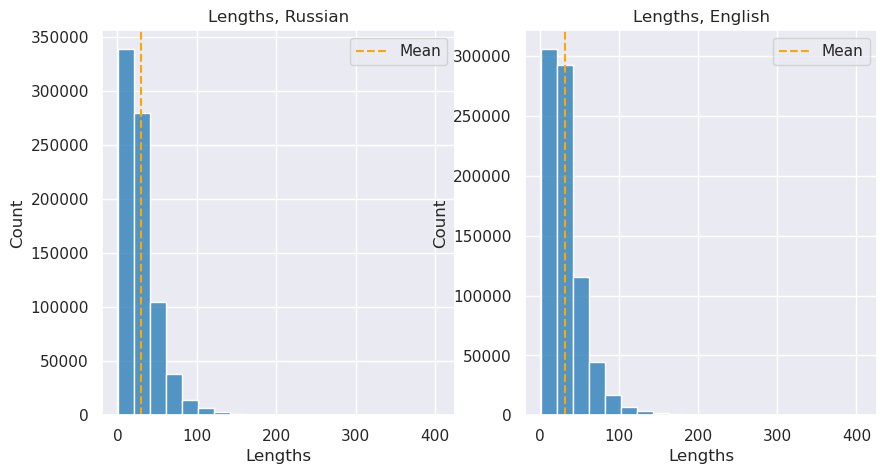

In [14]:
plot_characteristics(
    np.array(dataset["train"]["ru_len"]),
    np.array(dataset["train"]["en_len"]),
    title="Lengths",
    xlabel="Lengths",
)

Как видим, большая часть текстов имеет небольшую длину. Посмотрим на некоторые статистики этих распределений: среднее, разброс, 99% перцентиль

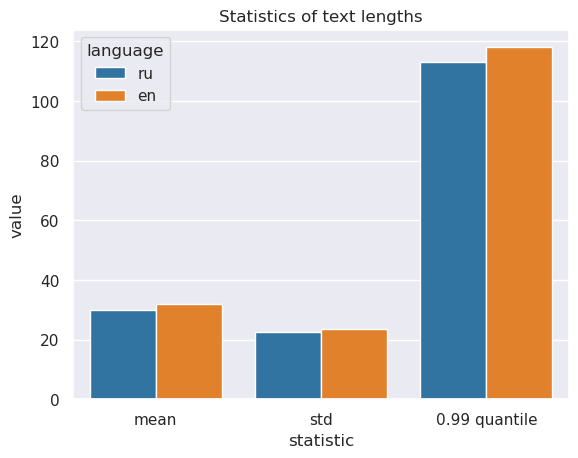

In [15]:
def plot_length_statistics(dataset: Dataset, quantile: float):
    ru_len_array = np.array(dataset["ru_len"])
    en_len_array = np.array(dataset["en_len"])

    len_stats = {"statistic": [], "value": [], "language": []}

    for statistic, name in zip(
        [np.mean, np.std, lambda a: np.quantile(a, quantile)], ["mean", "std", f"{quantile} quantile"]
    ):
        for arr, lang in zip([ru_len_array, en_len_array], ["ru", "en"]):
            len_stats["value"].append(statistic(arr))
            len_stats["statistic"].append(name)
            len_stats["language"].append(lang)

    len_stats = pd.DataFrame(len_stats)

    sns.barplot(len_stats, x="statistic", y="value", hue="language")
    plt.title("Statistics of text lengths")
    plt.show()

plot_length_statistics(dataset["train"], quantile=0.99)

Как видим, распределения довольно похожи. Тексты на английском языке в среднем немного длиннее, чем на русском.

Заметим также, что 99% всех текстов имеют длину менее 120 символов. Посмотрим на некоторые совсем длинные предложения

In [16]:
def show_long_sentences(
    dataset: Dataset,
    column: str,
    length_threshold: int,
    n_to_show: int = 5,
    seed: int | None = None,
) -> None:
    indices = np.argwhere(np.array(dataset[column]) >= length_threshold).reshape(-1)
    if seed:
        np.random.seed(seed)
    indices = np.random.choice(indices, size=n_to_show)

    for i in indices:
        i = i.item()
        print(f"{i}. {dataset[i]['ru']}")
        print(dataset[i]["en"])


show_long_sentences(dataset["train"], column="ru_len", length_threshold=200, seed=seed)

149808. она станет вам хорошим другом возлюбленной, преданной женой, а потом и матерью и не позволяйте мимолетным импульсам ослепить вас я вообще то не думал о браке я знаю, но вскоре задумаетесь я хочу что бы вы запомнили все что я вам сказала
Is she going to be a good friend besides a a sweetheart, a faithful wife, a consciencious mother. Now don't let passing impulses blind you. I wasn't thinking about marriage.
688088. Ведь это так просто для людей, сказать что им жаль, но никто не может сказать, что значит для матери потерять ребенка, потому что она единственная, кто понимает, кто может представить себе такого человека он будет расти.
It's so easy for people to be sorry, but no one can tell what it means to a mother to lose a child, because she's the only one who understands, who can imagine the kind of man he was going to grow up to be.
555287. Наши выводы относительно доклада начальника Таррона - заключенный, Йен Честертон виновен в совершении убийства, и заслуживает смертного п

Как видим, значения довольно адекватны. Тем не менее, мы скорее предпочтем убрать такие данные, чтобы модель обучалась на более однородных текстах

### 1.3. Разница в длинах

Рассмотрим некоторые проблемы, которые могут возникать, если мы начнем рассматривать переводы, которые сильно отличаются длинами
1. Съехавшие субтитры: на один и тот же фрагмент по-русски выдается одно, а по-английски - уже другое
2. Объединяющие субтитры: примерно то же самое. Субтитры для двух последовательных фрагментов могут показывать разом
3. Нередко в субтитрах бывает такое, что находятся фрагменты с поясняющим текстом. К примеру, многие переводчики добавляют пояснения к шуткам или культурным отсылкам. Их труд мы, конечно, уважаем, но для задачи обучения модели такие переводы кажутся не лучшим вариантом
4. Старая-добрая "отсебятина"

Для начала посмотрим на распределение разниц длин текстов

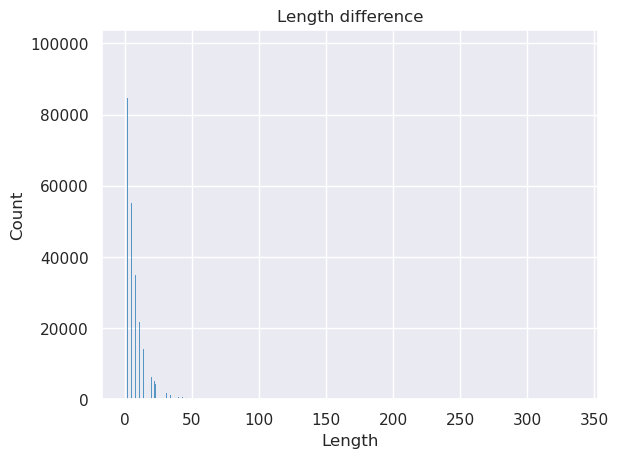

In [17]:
def plot_length_difference(
    length_ru: np.ndarray,
    length_en: np.ndarray,
    threshold: int | None = None,
    title="Length difference",
    label="Length",
    plot_kwargs: dict = {}
):
    diff = np.abs(length_ru - length_en)
    
    if threshold is not None:
        diff = diff[diff <= threshold]
    
    sns.histplot(x=diff, **plot_kwargs)
    plt.title(title)
    plt.xlabel(label)
    plt.show()


plot_length_difference(
    length_ru=np.array(dataset["train"]["ru_len"]),
    length_en=np.array(dataset["train"]["en_len"]),
)

Как видим, что-то здесь явно не так. Попробуем ограничить максимальную разницу в длинах каким-то более-менее адекватным числом и вновь посмотрим на это распределение

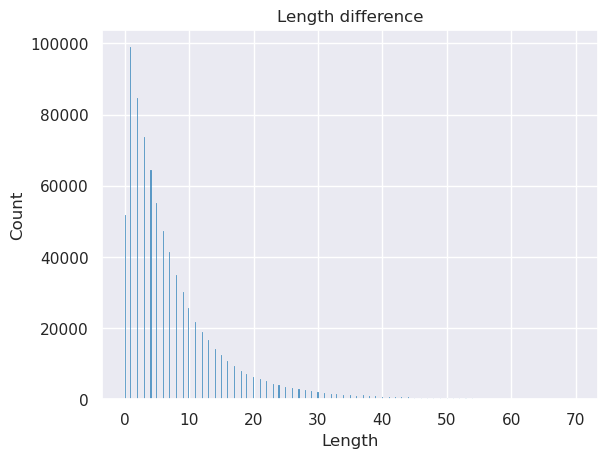

In [18]:
plot_length_difference(
    length_ru=np.array(dataset["train"]["ru_len"]),
    length_en=np.array(dataset["train"]["en_len"]),
    threshold=70
)

Посмотрим на некоторые примеры слишком длинных переводов

In [19]:
def show_long_translations(
    dataset: Dataset,
    column1: str,
    column2: str,
    length_diff_threshold: int,
    n_to_show: int = 10,
    seed: int | None = None,
) -> None:
    diff = np.abs(np.array(dataset[column1]) - np.array(dataset[column2]))
    indices = np.argwhere(diff >= length_diff_threshold).reshape(-1)
    if seed:
        np.random.seed(seed)
    indices = np.random.choice(indices, size=n_to_show)

    for i in indices:
        i = i.item()
        print(f"{i}. {dataset[i]['ru']}")
        print(dataset[i]["en"])


show_long_translations(
    dataset["train"],
    column1="ru_len",
    column2="en_len",
    length_diff_threshold=40,
    seed=seed,
)

570977. - Ты понял, что я требую продать дом?
- Well, as long as we have time... - You understand? - Do you realize I wanna sell the place?
65357. Небольшое осложнение, небольшое охлаждение, небольшое воспаление.
Just as I thought. A slight touch of monetary complications with bucolic semi-lunar contraptions of the flying trapezes.
422043. Мы убежали, но нас нашли и привезли назад.
We ran away, but they caught us and brought us back. And that's all there was to it.
405950. Не теряйте время, он нас не видит.
- All right, come on now, forget it. - You're wasting time, they didn't see us. - Bloody pilots.
449704. Он поклялся больше не прикасаться к сейфам.
Why haven't you asked Daniel? With everything that's happened, he doesn't want to touch a safe.
493020. Что это?
I wanna know why those parlors are still operating.
38305. а не его.
If something goes wrong with me, my father will kill you, not Lord Choi.
344326. - Добро пожаловать.
Will you put the mademoiselle's luggage in my car and b

Действительно, видно проблемы с такими текстами

Итак, отфильтруем датасет:
- Тексты не должны быть слишком длинными
- Длины не должны сильно отличаться

In [20]:
length_threshold = 125
length_diff_threshold = 35

print(f"Before filtering by length: {dataset.num_rows}")

dataset = dataset.filter(
    lambda example: example["ru_len"] < length_threshold
    and example["en_len"] < length_threshold
    and abs(example["ru_len"] - example["en_len"]) < length_diff_threshold
)

print(f"Before filtering by length: {dataset.num_rows}")

Before filtering by length: {'train': 789756, 'valid': 98720, 'test': 98720}


Filter:   0%|          | 0/789756 [00:00<?, ? examples/s]

Filter:   0%|          | 0/98720 [00:00<?, ? examples/s]

Filter:   0%|          | 0/98720 [00:00<?, ? examples/s]

Before filtering by length: {'train': 769701, 'valid': 96272, 'test': 96144}


### 1.4. Регистр

В дальнейшем для нашей работы пригодится сразу же перевести все тексты к нижнему регистру - сделаем это, чтобы модель обучалась проше

In [22]:
def example_to_lower(example: dict) -> dict:
    example["ru"] = example["ru"].lower()
    example["en"] = example["en"].lower()
    return example

dataset = dataset.map(example_to_lower)

Map:   0%|          | 0/769701 [00:00<?, ? examples/s]

Map:   0%|          | 0/96272 [00:00<?, ? examples/s]

Map:   0%|          | 0/96144 [00:00<?, ? examples/s]

In [23]:
dataset["train"][1]

{'ru': '- кто она?', 'en': "-what's her name?", 'ru_len': 10, 'en_len': 17}

### 1.5. Токенизация

Для токенизации я буду использовать библиотеку [Spacy](https://spacy.io/).

In [ ]:
nlp_ru = spacy.load("ru_core_news_sm")
nlp_en = spacy.load("en_core_web_sm")

Для начала я задам специальные токены: 
- `<unk>` - токен для неизвестного символа
- `<pad>` - токен для "набивки" последовательности до определенной длины
- `<sos>` - начало последовательности
- `<eos>` - конец последовательности

In [ ]:
unk_token = "<unk>"
pad_token = "<pad>"
sos_token = "<sos>"
eos_token = "<eos>"

special_tokens = [unk_token, pad_token, sos_token, eos_token]

При токенизации я буду добавлять в начало и в конец символы `<sos>` и `<eos>`.
Также для нашей задачи будет целесообразным приводить все тексты (и все токены) к нижнему регистру, но пока что мы и так имеем дело с текстами в нижнем регистре, так что будем иметь это в виду в дальнейшем (при инференсе)

In [ ]:
def tokenize_ru(s: str) -> List[str]:
    return [sos_token] + [token.text for token in nlp_ru.tokenizer(s)] + [eos_token]


def tokenize_en(s: str) -> List[str]:
    return [sos_token] + [token.text for token in nlp_en.tokenizer(s)] + [eos_token]

Посмотрим примеры токенизации некоторых текстов

In [ ]:
for i, (ru, en) in enumerate(zip(example_fragment["ru"], example_fragment["en"])):
    print(f"{i + 1}. {ru} --- {tokenize_ru(ru)}")
    print(f"{en} --- {tokenize_en(en)}")

1. Почему? --- ['<sos>', 'Почему', '?', '<eos>']
Why? --- ['<sos>', 'Why', '?', '<eos>']
2. - Кто она? --- ['<sos>', '-', 'Кто', 'она', '?', '<eos>']
-What's her name? --- ['<sos>', '-What', "'s", 'her', 'name', '?', '<eos>']
3. Не так быстро. --- ['<sos>', 'Не', 'так', 'быстро', '.', '<eos>']
Just a moment. --- ['<sos>', 'Just', 'a', 'moment', '.', '<eos>']
4. Я расскажу вам о маме. --- ['<sos>', 'Я', 'расскажу', 'вам', 'о', 'маме', '.', '<eos>']
I'll tell you what a mother is. --- ['<sos>', 'I', "'ll", 'tell', 'you', 'what', 'a', 'mother', 'is', '.', '<eos>']
5. Заходите в гости, буду ждать. --- ['<sos>', 'Заходите', 'в', 'гости', ',', 'буду', 'ждать', '.', '<eos>']
Come and see me. --- ['<sos>', 'Come', 'and', 'see', 'me', '.', '<eos>']


Теперь токенизируем все наши тексты

In [ ]:
dataset = dataset.map(
    lambda example: {
        "ru_tokens": tokenize_ru(example["ru"]),
        "en_tokens": tokenize_en(example["en"]),
    }
)
dataset

Parameter 'function'=<function <lambda> at 0x7f79c4a0de40> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/769701 [00:00<?, ? examples/s]

### 1.6. Словари

Теперь построим словари для обоих языков. Опять же, они будут небольшими, поскольку проект является не самым амбициозным

In [ ]:
class TokenVocabIterator:
    def __init__(self, dataset: Dataset, feature_name: str):
        self.dataset = dataset
        self.feature_name = feature_name
        self.i = 0
        self.length = dataset.num_rows

    def __iter__(self):
        return self

    def __next__(self) -> List[str]:
        if self.i < self.length:
            tokens = self.dataset[self.i][self.feature_name]
            self.i += 1
            return tokens
        raise StopIteration

In [ ]:
def load_or_build_vocab(dataset: Dataset, lang: Literal["en", "ru"], build_args: Dict = {}) -> Vocab:
    path = f"data/vocab_{lang}.pth"
    if not os.path.exists(path):
        vocab = build_vocab_from_iterator(
            TokenVocabIterator(dataset, f"{lang}_tokens"),
            **build_args
        )

        torch.save(vocab, path)
    else:
        vocab = torch.load(path)
    
    return vocab

In [ ]:
vocab_ru = load_or_build_vocab(
    dataset=dataset["train"],
    lang="ru",
    build_args={"specials": special_tokens, "min_freq": 3, "max_tokens": 40_000},
)

KeyboardInterrupt: 

In [ ]:
vocab_en = load_or_build_vocab(
    dataset=dataset["train"],
    lang="en",
    build_args={"specials": special_tokens, "min_freq": 3, "max_tokens": 30_000},
)

Проверим, что в обоих словарях индексы для специальных токенов совпадают

In [ ]:
for token in special_tokens:
    assert vocab_ru.get_stoi()[token] == vocab_en.get_stoi()[token], f"Error! Token {token} is diffenet in two vocabs"

Также достанем индексы для всех этих токенов

In [ ]:
unk_index = vocab_ru.get_stoi()[unk_token]
pad_index = vocab_ru.get_stoi()[pad_token]
sos_index = vocab_ru.get_stoi()[sos_token]
eos_index = vocab_ru.get_stoi()[eos_token]

Также в словарях сделаем дефолтным индексом (то есть тем, который словарь будет возвращать на неизвестный токен) значение `unk_index`

In [ ]:
vocab_en.set_default_index(unk_index)
vocab_ru.set_default_index(unk_index)

Посмотрим, каких длин получились токены в обоих словарях

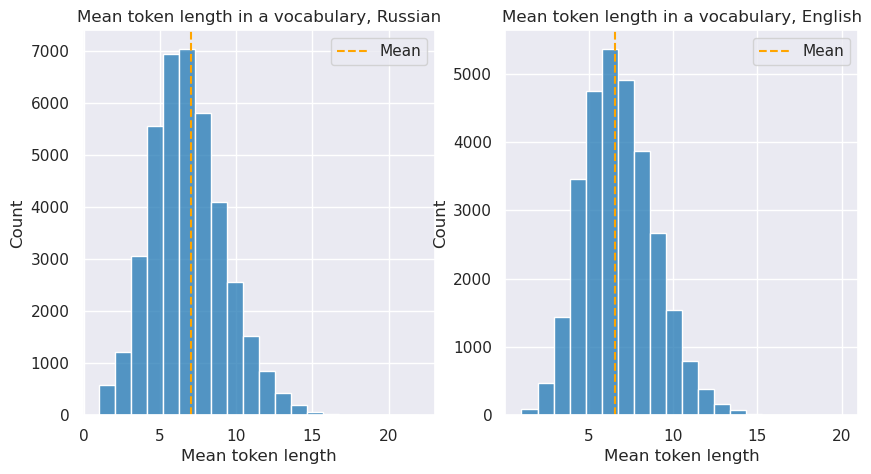

In [ ]:
plot_characteristics(
    x1=np.array([len(s) for s in vocab_ru.get_stoi().keys()]),
    x2=np.array([len(s) for s in vocab_en.get_stoi().keys()]),
    title="Mean token length in a vocabulary",
    xlabel="Mean token length"
)

Как видим, в английском языке распределение выглядит довольно странным, но в целом находится в разумных пределах. Разброс кажется значительно меньшим

Интересно также, насколько отличается в среднем количество токенов в двух языках. Для исследования этого отличия, сначала вновь замапим некоторые значения в датасет:
- `ru_tokenized_length`: длина токенизированной последовательности на русском языке
- `en_tokenized_length`: длина токенизированной последовательности на английском языке
  
Также токены переведем в индексы в наших словарях:
- `ru_ids`: последовательность индексов в словаре для русского языка
- `en_ids`: последовательность индексов в словаре для английского языка
  
Причем сделаем это, переведя их сразу же в `torch.Tensor`

In [ ]:
dataset = dataset.map(
    lambda example: {
        "ru_tokenized_length": len(example["ru_tokens"]),
        "en_tokenized_length": len(example["en_tokens"]),
        "ru_ids": vocab_ru.lookup_indices(example["ru_tokens"]),
        "en_ids": vocab_en.lookup_indices(example["en_tokens"]),
    }
).with_format(type="torch", columns=["ru_ids", "en_ids"], output_all_columns=True)

dataset

Loading cached processed dataset at /home/ilyas/Documents/study/ml/machine_translation/data/cache/csv/default-a9ae0552c7a89f5b/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-f933679fcc94bffa.arrow
Loading cached processed dataset at /home/ilyas/Documents/study/ml/machine_translation/data/cache/csv/default-a9ae0552c7a89f5b/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-69f3d042b839e1fa.arrow
Loading cached processed dataset at /home/ilyas/Documents/study/ml/machine_translation/data/cache/csv/default-a9ae0552c7a89f5b/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-e3f77cdc86607b8f.arrow


DatasetDict({
    train: Dataset({
        features: ['ru', 'en', 'ru_len', 'en_len', 'ru_tokens', 'en_tokens', 'ru_tokenized_length', 'en_tokenized_length', 'ru_ids', 'en_ids'],
        num_rows: 769701
    })
    valid: Dataset({
        features: ['ru', 'en', 'ru_len', 'en_len', 'ru_tokens', 'en_tokens', 'ru_tokenized_length', 'en_tokenized_length', 'ru_ids', 'en_ids'],
        num_rows: 96272
    })
    test: Dataset({
        features: ['ru', 'en', 'ru_len', 'en_len', 'ru_tokens', 'en_tokens', 'ru_tokenized_length', 'en_tokenized_length', 'ru_ids', 'en_ids'],
        num_rows: 96144
    })
})

Посмотрим на то, сколько получилось токенов в наших текстах

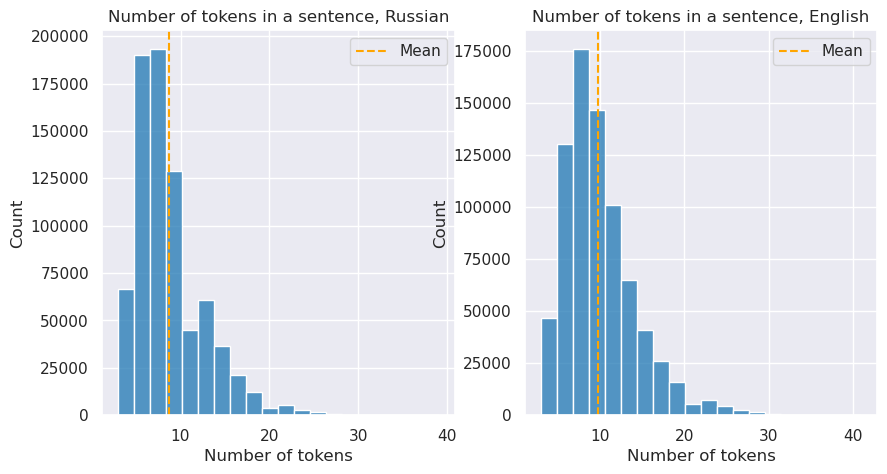

In [ ]:
plot_characteristics(
    x1=np.array(dataset["train"]["ru_tokenized_length"]),
    x2=np.array(dataset["train"]["en_tokenized_length"]),
    title="Number of tokens in a sentence",
    xlabel="Number of tokens"
)

Попробуем посмотреть какой-нибудь текст, где такое большое количество токенов

In [ ]:
show_long_sentences(dataset["train"], column="ru_tokenized_length", length_threshold=35)

545198. ...32, 33, 34, 35, 36, 37, 38, 39, 40 47, 48, 49, 50, 51, 52, 53, 54,
...32, 33, 34, 35, 36, 37, 38, 39, 40 47, 48, 49, 50, 51, 52, 53, 54,
417332. 3, 4, 5, 6, 7, 8, 9, 10, 11... 12, 13, 14, 15, 16, 17, 18, 19, 20.
12, 13, 14, 15, 16, 17, 18, 19, 20.
154449. = О, да, да! Фея Утренней Зари, если это не слишком много, чтобы просить,.. = Я хотела бы быть такой же красивой, как ты.
Yes, yes, Morning Fairy, and if it isn't too much to ask I'd like to be as pretty as you are.
295578. Вот и я так думала, когда выходила замуж за музыканта, но с тех пор, как мы сказали "Да", я только и слышу, что "Нет".
Yeah, that's what I thought when I married a bandleader, but ever since we said "I do", there are so many things we don't.
545198. ...32, 33, 34, 35, 36, 37, 38, 39, 40 47, 48, 49, 50, 51, 52, 53, 54,
...32, 33, 34, 35, 36, 37, 38, 39, 40 47, 48, 49, 50, 51, 52, 53, 54,


Значения вполне приемлемые, просто зачастую в них достаточно много знаков препинания и цифр

## 2. Model

Обучать я буду модель `Sequence-to-Sequence`, основанную на рекуррентных нейронных сетях (`RNN`). Она состоит из:
- `Encoder` - часть, которая переводит последовательность id токенов в векторное пространство (embedding)
- `Decoder` - часть, которая по эмбеддингу генерирует новую последовательность
- `Sequence2Sequence` - полная модель, включающая в себя `Encoder` и `Decoder`

### 2.1. Encoder

На вход подается последовательность из id для токенов исходного языка. Encoder преобразует эту последовательность в некоторый вектор, вложенный в пространство меньшей размерности (т.е. эмбеддинг). Поскольку мы будем пользоваться не обычным RNN, а немного более навороченным LSTM, encoder будет отдавать нам пару - `hidden state` и `cell state`. Полученный вектор будет использоваться декодером как вектор "контекста"

In [ ]:
class Encoder(nn.Module):
    def __init__(
        self,
        input_size: int,
        embedding_size: int,
        num_layers: int,
        hidden_size: int,
        p_dropout: float = 0,
    ) -> None:
        """
        Constructor for Encoder

        Args:
            input_size (int): size of an input vocabulary
            embedding_size (int): number of features in token embeddings for input vocabulary
            num_layers (int): number of LSTM layers in Encoder
            hidden_size (int): number of features in the hidden state as well as in resulting embedding vector for an input sequence
            p_dropout (float, optional): probability of dropout. Dropout is applied after 
                embedding layer and after every LSTM layer except for the last one.
                Defaults to 0.
        """
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.embedding_size = embedding_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.p_dropout = p_dropout

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.dropout = nn.Dropout(p_dropout)

        rnn_dropout = p_dropout if num_layers > 1 else None
        self.rnn = nn.LSTM(
            input_size=embedding_size,
            hidden_size=hidden_size,
            batch_first=True,
            dropout=rnn_dropout,
            num_layers=self.num_layers,
        )

    def forward(
        self, input: torch.Tensor, lengths: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass

        Args:
            input (torch.Tensor): input tensor with padded rows of size (batch_size, max_length)
            lengths (torch.Tensor): tensor of actual lengths, (batch_size,)

        Returns:
            torch.Tensor: hidden state of LSTM of size (num_layers, batch_size, hidden_size)
            torch.Tensor: cell state of LSTM of size (num_layers, batch_size, hidden_size)
        """

        # embeds: (batch_size, max_length, embedding_size)
        embeds = self.embedding(input)
        embeds = self.dropout(embeds)

        packed_embeds = pack_padded_sequence(
            embeds, lengths, batch_first=True, enforce_sorted=False
        )

        # output: packed sequence, if unpacked it will be (batch_size, max_length, hidden_size)
        # hidden, cell: (num_layers, batch_size, hidden_size)
        output, (hidden, cell) = self.rnn(packed_embeds)

        return hidden, cell

### 2.2. Decoder

Задача декодера - по в

In [ ]:
class Decoder(nn.Module):
    def __init__(
        self,
        embedding_size: int,
        num_layers: int,
        hidden_size: int,
        output_size: int,
        p_dropout: float = 0,
    ) -> None:
        """
        Constructor for Decoder

        Args:
            embedding_size (int): number of features in token embeddings for output vocabulary
            num_layers (int): number of LSTM layers in Decoder
            hidden_size (int): number of features in the hidden state
            output_size (int): size of an output vocabulary
            p_dropout (float, optional): probability of dropout. Dropout is applied after
                embedding layer and after every LSTM layer except for the last one.
                Defaults to 0.
        """
        super(Decoder, self).__init__()
        self.embedding_size = embedding_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.p_dropout = p_dropout

        self.embedding = nn.Embedding(
            num_embeddings=output_size, embedding_dim=embedding_size
        )

        self.dropout = nn.Dropout(p=p_dropout)

        rnn_dropout = p_dropout if num_layers > 1 else None
        self.rnn = nn.LSTM(
            input_size=embedding_size,
            hidden_size=hidden_size,
            batch_first=True,
            dropout=rnn_dropout,
            num_layers=self.num_layers,
        )
        self.linear = nn.Linear(in_features=hidden_size, out_features=output_size)

    def forward(
        self, input: torch.Tensor, hidden: torch.Tensor, cell: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Forward pass

        Args:
            input (torch.Tensor): input tensor of size (batch_size, 1). For every batch
                there is exactly one input token id
            hidden (torch.Tensor): hidden of size (num_layers, batch_size, hidden_size)
            cell (torch.Tensor): cell of size (num_layers, batch_size, hidden_size)

        Returns:
            torch.Tensor: outputs (torch.Tensor): (batch_size, output_size)
            torch.Tensor: hidden (torch.Tensor): hidden of size (num_layers, batch_size, hidden_size)
            torch.Tensor: cell (torch.Tensor): cell of size (num_layers, batch_size, hidden_size)
        """
        # embeds: (batch_size, 1, embedding_size)
        embeds = self.embedding(input)
        embeds = self.dropout(embeds)

        # rnn_outputs: (batch_size, 1, hidden_size)
        # hidden: (num_layers, batch_size, hidden_size)
        # cell: (num_layers, batch_size, hidden_size)
        rnn_outputs, (hidden, cell) = self.rnn(embeds, (hidden, cell))

        # rnn_outputs: (batch_size, hidden_size)
        rnn_outputs = rnn_outputs.squeeze(1)

        # outputs: (batch_size, output_size)
        outputs = self.linear(rnn_outputs)

        return outputs, hidden, cell

## 2.3. Sequence-to-Sequence

In [ ]:
class Sequence2Sequence(nn.Module):
    def __init__(
        self,
        encoder: Encoder,
        decoder: Decoder,
        device: torch.device,
        sos_index: int
    ) -> None:
        """
        Sequence2Sequence model

        Args:
            encoder (Encoder): encoder to encode an input sequence
            decoder (Decoder): decoder to generate output sequence
            device (torch.device): device used for computations
            sos_index (int): index of the token for start of sequence
        """
        super(Sequence2Sequence, self).__init__()
        self.encoder = encoder.to(device)
        self.decoder = decoder.to(device)

        assert (
            self.encoder.hidden_size == self.decoder.hidden_size
        ), "Encoder and Decoder must have the same hidden_size"
        assert (
            self.encoder.num_layers == self.decoder.num_layers
        ), "Encoder and Decoder must have the same num_layers"

        self.sos_index = sos_index
        self.device = device

    def forward(
        self,
        input: torch.Tensor,
        lengths: torch.Tensor,
        target: torch.Tensor,
        teacher_forcing_ratio: float = 0.5,
    ) -> torch.Tensor:
        """
        Forward pass for Sequence2Sequence

        Args:
            input (torch.Tensor): input tensor with padded rows of size (batch_size, max_length)
            lengths (torch.Tensor): tensor of actual lengths, (batch_size,)
            target (torch.Tensor): tensor of actual target value for each token id,
                also has padded rows, size is (batch_size, max_length)
            teacher_forcing_ratio (float, optional): probability of using actual target
                as a model output in the training loop instead of a predicted value. Defaults to 0.5.

        Returns:
            torch.Tensor: output of size (batch_size, max_length, output_size) - a tensor of predictions:
                for each sequence in a batch, for each token in a sequence - a model's prediction for next token
        """

        # (batch_size, max_length)
        input = input.to(self.device)
        # (batch_size, max_length)
        target = target.to(self.device)

        batch_size = input.size()[0]
        max_length = target.size()[1]

        # (batch_size, max_length, output_size)
        outputs = torch.zeros(
            batch_size, max_length, self.decoder.output_size, device=self.device
        )

        # hidden and cell: (num_layers, batch_size, hidden_size)
        hidden, cell = self.encoder(input, lengths)

        # (batch_size, 1) of <sos>
        decoder_input = torch.full(
            (batch_size, 1), fill_value=self.sos_index, device=self.device
        )
        for i in range(1, max_length):
            # out: (batch_size, output_size)
            # hidden and cell: (num_layers, batch_size, hidden_size)
            out, hidden, cell = self.decoder(decoder_input, hidden, cell)

            if random.random() < teacher_forcing_ratio:
                # We use real target as next decoder input

                # (batch_size, 1)
                decoder_input = target[:, i].unsqueeze(1)
            else:
                # We use previous decoder output as its next input

                # (batch_size, 1)
                decoder_input = out.argmax(1).unsqueeze(1)

            # out: (batch_size, 1, output_size)
            out = out.squeeze(1)
            # Save outputs: for every batch, for this number of token (i), outputs (probabilities for each token)
            outputs[:, i, :] = out

        return outputs

## 3. Utility

Перед тем как мы нанчнем обучать модель, нужно сделать еще несколько шагов

### 3.1. DataLoaders
Нам нужна некоторая обертка над данными, которая сможет доставать сразу некоторую группу (мини-батч)

In [ ]:
def dataloader_collate_fn(batch: dict) -> dict:
    ru_ids = [x["ru_ids"] for x in batch]
    en_ids = [x["en_ids"] for x in batch]

    ru_lengths = torch.IntTensor([x["ru_tokenized_length"] for x in batch])
    en_lengths = torch.IntTensor([x["en_tokenized_length"] for x in batch])

    ru_ids = pad_sequence(ru_ids, batch_first=True, padding_value=pad_index)
    en_ids = pad_sequence(en_ids, batch_first=True, padding_value=pad_index)

    return {
        "ru": ru_ids,
        "en": en_ids,
        "en_text": [x["en"] for x in batch], # for BLEU
        "ru_lengths": ru_lengths,
        "en_lengths": en_lengths,
    }

def get_dataloaders(dataset_dict: DatasetDict, batch_size: int, collate_fn: callable):
    return (
        DataLoader(
            dataset_dict["train"],
            batch_size=batch_size,
            collate_fn=collate_fn,
            shuffle=True,
        ),
        DataLoader(
            dataset_dict["valid"],
            batch_size=batch_size,
            collate_fn=collate_fn,
        ),
        DataLoader(
            dataset_dict["test"],
            batch_size=batch_size,
            collate_fn=collate_fn,
        ),
    )

### 3.2. Translator class

Также создадим класс, который поможет нам опробовать модель в инференсе. Он также объединит в себе некоторые функции, такие как токенизация (в которой мы также будем приводить строку к нижнему регистру) и перевод токенов в последовательность id

In [ ]:
class Translator:
    def __init__(
        self,
        seq2seq: Sequence2Sequence,
        nlp_input: spacy.Language,
        nlp_output: spacy.Language,
        vocab_input: Vocab,
        vocab_output: Vocab,
        sos_token: str,
        eos_token: str,
        unk_token: str,
        pad_token: str,
        sos_index: int,
        eos_index: int,
        max_tokens: int = 100,
    ) -> None:
        """
        Translator from Input language to Output language

        Args:
            seq2seq (Sequence2Sequence):
            nlp_input (spacy.Language):
            nlp_output (spacy.Language):
            vocab_input (Vocab):
            vocab_output (Vocab):
            sos_token (str):
            eos_token (str):
            unk_token (str):
            pad_token (str):
            sos_index (int):
            eos_index (int):
            max_tokens (int, optional): max amount of tokens to generate when translating a sentence. Defaults to 100.
        """
        self.seq2seq = seq2seq
        self.nlp_input = nlp_input
        self.nlp_output = nlp_output
        self.vocab_input = vocab_input
        self.vocab_output = vocab_output
        self.sos_token = sos_token
        self.eos_token = eos_token
        self.unk_token = unk_token
        self.pad_token = pad_token

        self.special_tokens = [sos_token, eos_token, unk_token, pad_token]

        self.sos_index = sos_index
        self.eos_index = eos_index
        self.max_tokens = max_tokens

    def tokenize_input(self, s: str) -> List[str]:
        return (
            [self.sos_token]
            + [token.text for token in self.nlp_input.tokenizer(s.lower())]
            + [self.eos_token]
        )

    def tokenize_output(self, s: str) -> List[str]:
        return (
            [self.sos_token]
            + [token.text for token in self.nlp_output.tokenizer(s.lower())]
            + [self.eos_token]
        )

    def detokenize(self, tokens: List[str]) -> str:
        # remove <sos>, <eos>, <unk>, <pad>
        filtered = filter(lambda x: x not in self.special_tokens, tokens)
        return " ".join(filtered)

    def translate_to_tokens(self, s: str, do_sample: bool = False) -> List[str]:
        """
        Method to translate a sentence to a sequence of tokens

        Args:
            s (str): short sentence to translate
            do_sample (bool, optional): whether to use sampling from a model output
                or to use the most possible token. Defaults to False.

        Returns:
            List[str]: a sequence of tokens in an output language
        """
        self.seq2seq.eval()
        input_tokens = self.tokenize_input(s)
        output_indices = self.vocab_input.lookup_indices(input_tokens)

        # input: (1, length)
        encoder_input = torch.tensor(
            output_indices, device=self.seq2seq.device
        ).unsqueeze(0)
        encoder_lengths = torch.tensor([len(input_tokens)])

        # hidden, cell: (num_layers, 1, hidden_size)
        hidden, cell = self.seq2seq.encoder(encoder_input, encoder_lengths)

        # (1, max_tokens)
        output_tensor = torch.zeros(
            size=(1, self.max_tokens), dtype=torch.int32, device=self.seq2seq.device
        )
        output_tensor[0][0] = self.sos_index

        length = self.max_tokens

        for i in range(1, self.max_tokens):
            # decoder_input: (1, 1)
            decoder_input = output_tensor[0, i - 1].reshape(1, 1)

            # decoder_output: (1, output_size)
            decoder_output, hidden, cell = self.seq2seq.decoder(
                decoder_input, hidden, cell
            )
            # decoder_output: (output_size)
            decoder_output = decoder_output.squeeze(0)

            # out token id
            out = (
                torch.distributions.Categorical(logits=decoder_output).sample()
                if do_sample
                else decoder_output.argmax()
            )

            output_tensor[0, i] = out

            if out.item() == self.eos_index:
                length = i + 1
                break

        output_indices = output_tensor.reshape(-1)[:length].tolist()
        output_tokens = self.vocab_output.lookup_tokens(output_indices)
        return output_tokens

    def translate(self, s: str, do_sample: bool = False) -> str:
        """
        Method to translate a sentence

        Args:
            s (str): short sentence to translate
            do_sample (bool, optional): whether to use sampling from a model output
                or to use the most possible token. Defaults to False.

        Returns:
            str: translation in an output language
        """
        return self.detokenize(self.translate_to_tokens(s, do_sample=do_sample))

    def output_to_texts(self, output: torch.Tensor) -> List[str]:
        """
        Convert model output to a list of translated texts

        Args:
            output (torch.Tensor): tensor of model output of size (batch_size, max_length, output_size)

        Returns:
            List[str]: list with translated texts
        """
        # output (batch_size, max_length, output_size)

        # indices (batch_size, max_length)
        indices = torch.argmax(output, dim=2)

        lst = []

        batch_size = indices.size()[0]
        for i in range(batch_size):
            indices_list = indices[i].tolist()

            tokens_list = self.vocab_output.lookup_tokens(indices_list)

            lst.append(self.detokenize(tokens_list))

        return lst

### 3.3. Checkpoints

Задача стоит довольно трудоемкая, обучение модели будет долгим. Поэтому нужно обязательно позаботиться о том, чтобы сохранять и загружать ее состояние

In [ ]:
def save_checkpoint(
    seq2seq: Sequence2Sequence,
    optimizer: torch.optim.Optimizer,
    epoch: int,
    train_loss: List[float],
    train_metric: List[float],
    valid_loss: List[float],
    valid_metric: List[float],
    path: str = "model-data/translator.pth",
) -> None:
    checkpoint = {
        "seq2seq_state_dict": seq2seq.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": epoch,
        "train_loss": train_loss,
        "train_metric": train_metric,
        "valid_loss": valid_loss,
        "valid_metric": valid_metric,
    }
    torch.save(checkpoint, path)


def load_checkpoint(
    path: str,
) -> dict:
    return torch.load(path)

### 3.4. Metric

Нужно выбрать адекватную метрику для нашей задачи. Я остановился на [BLEU](https://en.wikipedia.org/wiki/BLEU) - одной из самых популярных метрик для задачи машинного перевода. Однако подсчет этой метрики после каждой эпохи занимает довольно времени, поэтому в процессе обучения я буду считать другую метрику - [Perplexity](https://huggingface.co/docs/transformers/en/perplexity), а BLEU посчитаем в самом конце, на тестовой выборке 

## 4. Training

Пришло время написать цикл обучения модели

### 4.1. Графики

Функция, которая будет визуализировать значение Loss-function и метрики на тренировочной и валидационной выборках

In [ ]:
def plot_losses(
    train_loss: List[float],
    train_metric: List[float],
    val_loss: List[float],
    val_metric: List[float],
    loss_label: str = "loss",
    metric_label: str = "metric",
):
    clear_output()
    n_epochs = len(train_loss)
    epochs = np.arange(1, n_epochs + 1)

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].plot(epochs, train_loss, marker=".", label=f"train {loss_label}")
    ax[0].plot(epochs, val_loss, marker=".", label=f"val {loss_label}")
    ax[0].set_xlabel("epoch")
    ax[0].set_ylabel(loss_label)
    ax[0].set_title(f"epoch -- {loss_label}")

    ax[1].plot(epochs, train_metric, marker=".", label=f"train {metric_label}")
    ax[1].plot(epochs, val_metric, marker=".", label=f"val {metric_label}")
    ax[1].set_xlabel("epoch")
    ax[1].set_ylabel(metric_label)
    ax[1].set_title(f"epoch -- {metric_label}")

    ax[0].legend()
    ax[1].legend()
    plt.show()

### 4.2. Тренирочный цикл

Проходим по всем батчам, производя обратное распространение ошибки, считаем и возвращаем лосс и метрику (perplexity)

Также не будем забывать про проблему "взрывных градиентов" (exploding gradients), поэтому будем обрезать значения градиентов

In [ ]:
def train_epoch(
    train_loader: DataLoader,
    epoch: int,
    num_epochs: int,
    model: Sequence2Sequence,
    optimizer: torch.optim.Optimizer,
    criterion: torch.nn.Module,
    device: torch.device,
    teacher_forcing_ratio: float = 0.5,
) -> Tuple[float, float]:
    model.train()

    current_loss = 0

    for batch in tqdm(train_loader, desc=f"Training, epoch {epoch}/{num_epochs}"):
        optimizer.zero_grad()

        input = batch["ru"].to(device)
        lengths = batch["ru_lengths"]
        target = batch["en"].to(device)
        batch_size = input.size()[0]

        pred = model(
            input,
            lengths,
            target=target,
            teacher_forcing_ratio=teacher_forcing_ratio,
        )

        pred = pred[:, 1:, :].transpose(1, 2)
        target = target[:, 1:]

        loss = criterion(pred, target)

        loss.backward()
        
        clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()

        current_loss += loss.item() * batch_size

        loss = None

    total_loss = current_loss / len(train_loader)

    return total_loss, np.exp(total_loss)

### 4.3. Валидационный цикл

Проходим по всем батчам, считаем и возвращаем лосс и метрику

In [ ]:
def validate_epoch(
    val_loader: DataLoader,
    epoch: int,
    num_epochs: int,
    model: Sequence2Sequence,
    criterion: torch.nn.Module,
    device,
) -> Tuple[float, float]:
    current_loss = 0
    model.eval()
    for batch in tqdm(val_loader, desc=f"Validating, epoch {epoch}/{num_epochs}"):
        input = batch["ru"].to(device)
        lengths = batch["ru_lengths"]
        target = batch["en"].to(device)

        batch_size = input.size()[0]

        pred = model(
            input,
            lengths,
            target=target,
            teacher_forcing_ratio=0,
        )

        pred = pred[:, 1:, :].transpose(1, 2)
        target = target[:, 1:]

        loss = criterion(pred, target)

        current_loss += loss.item() * batch_size

        loss = None

    total_loss = current_loss / len(val_loader)

    return total_loss, np.exp(total_loss)

### 4.4. Функция обучения

1. Если месть сохраненная модель, загружаем ее
2. Проходим по каждой эпохе:
   - Тренировочный цикл
   - Шаг планировщика (scheduler)
   - Валидационный цикл
   - Построение графиков
   - Сохранение состояния: модели, оптимизатора, метрик и лосса
   - Если модель еще и стала лучше, то сохраняем ее как best model
   - Показываем примеры перевода

In [ ]:
def train(
    seq2seq: Sequence2Sequence,
    optimizer: torch.optim.Optimizer,
    criterion: torch.nn.Module,
    scheduler,
    num_epochs: int,
    train_loader: DataLoader,
    val_loader: DataLoader,
    teacher_forcing_ratio: float = 0.5,
    path_to_save: str = "model/translator-training.pt",
    path_to_save_best: str = "model/translator-best.pt",
    loss_label: str = "loss",
    metric_label: str = "metric",
    translator: Translator | None = None,
    examples_to_translate: List[str] = [],
) -> Tuple[List[float], List[float], List[float], List[float]]:
    train_loss, train_metric = [], []
    val_loss, val_metric = [], []
    last_epoch = 0

    if os.path.exists(path_to_save):
        checkpoint = load_checkpoint(path_to_save)
        seq2seq.load_state_dict(checkpoint["seq2seq_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        train_loss, train_metric, val_loss, val_metric = (
            checkpoint["train_loss"],
            checkpoint["train_metric"],
            checkpoint["valid_loss"],
            checkpoint["valid_metric"],
        )
        last_epoch = checkpoint["epoch"]

    device = seq2seq.device
    for epoch in range(last_epoch + 1, num_epochs + 1):
        loss_value, metric_value = train_epoch(
            train_loader,
            epoch,
            num_epochs,
            seq2seq,
            optimizer,
            criterion,
            device,
            teacher_forcing_ratio,
        )
        train_loss.append(loss_value)
        train_metric.append(metric_value)

        if scheduler:
            scheduler.step()

        with torch.no_grad():
            loss_value, metric_value = validate_epoch(
                val_loader, epoch, num_epochs, seq2seq, criterion, device
            )

        val_loss.append(loss_value)
        val_metric.append(metric_value)

        plot_losses(
            train_loss,
            train_metric,
            val_loss,
            val_metric,
            loss_label=loss_label,
            metric_label=metric_label,
        )

        print("Saving checkpoint...")
        save_checkpoint(
            seq2seq,
            optimizer,
            epoch,
            train_loss,
            train_metric,
            val_loss,
            val_metric,
            path=path_to_save,
        )

        if val_metric[-1] == min(val_metric):
            print("Saving checkpoint as best...")
            save_checkpoint(
                seq2seq,
                optimizer,
                epoch,
                train_loss,
                train_metric,
                val_loss,
                val_metric,
                path=path_to_save_best,
            )

        if translator is not None:
            print("Translating examples:")
            for i, s in enumerate(examples_to_translate):
                translated = translator.translate(s)
                print(f"{i + 1}. {s}")
                print(translated)
                print("****************")

    return train_loss, train_metric, val_loss, val_metric

### 4.5. Создание моделей

Во-первых, еще раз зафиксируем сид

In [ ]:
set_seed(seed)

К сожалению, создать такую же сложную модель, как и в оригинальной статье, на которую я частично опираюсь (['Sequence to Sequence Learning with Neural Networks'](https://arxiv.org/abs/1409.3215)), не получится, поэтому гиперпараметры модели выставим поскромнее

In [ ]:
EMBEDDING_SIZE = 300
NUM_LAYERS = 4
HIDDEN_SIZE = 300
P_DROPOUT = 0.3
INPUT_SIZE = len(vocab_ru)
OUTPUT_SIZE = len(vocab_en)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is: {device}")

encoder = Encoder(INPUT_SIZE, EMBEDDING_SIZE, NUM_LAYERS, HIDDEN_SIZE, P_DROPOUT)
decoder = Decoder(EMBEDDING_SIZE, NUM_LAYERS, HIDDEN_SIZE, OUTPUT_SIZE, P_DROPOUT)

seq2seq = Sequence2Sequence(
    encoder,
    decoder,
    device,
    sos_index=sos_index,
)

print(f"Num params: {sum(p.numel() for p in seq2seq.parameters())}")

Device is: cuda
Num params: 35807398


In [ ]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 10
TEACHER_FORCING_RATIO = 0.5
BATCH_SIZE = 128

translator = Translator(
    seq2seq=seq2seq,
    nlp_input=nlp_ru,
    nlp_output=nlp_en,
    vocab_input=vocab_ru,
    vocab_output=vocab_en,
    sos_token=sos_token,
    eos_token=eos_token,
    unk_token=unk_token,
    pad_token=pad_token,
    sos_index=sos_index,
    eos_index=eos_index,
    max_tokens=100,
)


optimizer = torch.optim.Adam(seq2seq.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=[3, 5, 7, 9], gamma=0.5
)
criterion = torch.nn.CrossEntropyLoss(ignore_index=pad_index).to(device)

train_loader, valid_loader, test_loader = get_dataloaders(
    dataset, batch_size=BATCH_SIZE, collate_fn=dataloader_collate_fn
)


examples_to_translate = [
    "я должен сказать тебе правду: я волк",
    "давай что-нибудь простое: привет, мир!",
    "как же хочется, чтобы меня взяли на работу",
]

In [ ]:
train_loss, train_metric, valid_loss, valid_metric = train(
    seq2seq=seq2seq,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    val_loader=valid_loader,
    teacher_forcing_ratio=TEACHER_FORCING_RATIO,
    path_to_save="model-data/translator-training.pth",
    path_to_save_best="model-data/translator-best.pth",
    loss_label="Cross-Entropy",
    metric_label="Perplexity",
    translator=translator,
    examples_to_translate=examples_to_translate,
)

Training, epoch 1/10:   0%|          | 0/6014 [00:00<?, ?it/s]

KeyboardInterrupt: 

Наконец, посчитаем BLEU score на тестовой выборке

In [ ]:
def test_model(
    model: Sequence2Sequence, translator: Translator, test_loader: DataLoader
) -> Tuple[float, float, float]:
    total_loss = 0
    total_score = 0
    model.eval()
    device = model.device

    for batch in tqdm(test_loader, desc=f"Calculating BLEU score"):
        input = batch["ru"].to(device)
        lengths = batch["ru_lengths"]
        target = batch["en"].to(device)

        batch_size = input.size()[0]

        pred = model(
            input,
            lengths,
            target=target,
            teacher_forcing_ratio=0,
        )

        translations = translator.output_to_texts(pred)
        total_score += bleu_score(translations, batch["en_text"])

        pred = pred[:, 1:, :].transpose(1, 2)
        target = target[:, 1:]

        loss = criterion(pred, target)

        total_loss += loss.item() * batch_size

        loss = None

    total_score /= len(test_loader)
    total_loss /= len(test_loader)

    return total_loss, np.exp(total_loss), total_score

In [ ]:
test_loss, test_perplexity, test_bleu = test_model(model=seq2seq, translator=translator, test_loader=test_loader)

print(f"Cross-Entropy: {test_loss}")
print(f"Perplexity: {test_perplexity}")
print(f"BLEU score: {test_bleu}")

Calculating BLEU score:   0%|          | 0/8 [00:00<?, ?it/s]

Cross-Entropy: 754.0702137947083
Perplexity: inf
BLEU score: 0.0


/tmp/ipykernel_66362/1068185736.py:38: RuntimeWarning: overflow encountered in exp
  return total_loss, np.exp(total_loss), total_score


Ресурсы, которые помогли мне с разработкой проекта:
- Статья ['Sequence to Sequence Learning with Neural Networks'](https://arxiv.org/abs/1409.3215)
- Ноутбук с гитхаба [benrevett](https://github.com/bentrevett/pytorch-seq2seq/blob/main/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb)